In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [79]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [80]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t', # Treats question marks (?) as missing values (NaN) in the data.
                          sep=' ', skipinitialspace=True) # the delimiter between values in the CSV file.


In [81]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [82]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [83]:
dataset = dataset.dropna()

In [84]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [85]:
# pd.get_dummies(...): This function converts categorical variables into dummy/indicator variables (one-hot encoding).
# dataset: The DataFrame containing the categorical Origin column.
# columns=['Origin']: Specifies the column to be one-hot encoded.
# prefix='': Sets an empty prefix for the generated dummy columns.
# prefix_sep='': Sets an empty separator between the prefix and category names.
# dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
# dataset.tail()

In [86]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index) # dropping all rows from the original dataset that are present in the train_dataset.

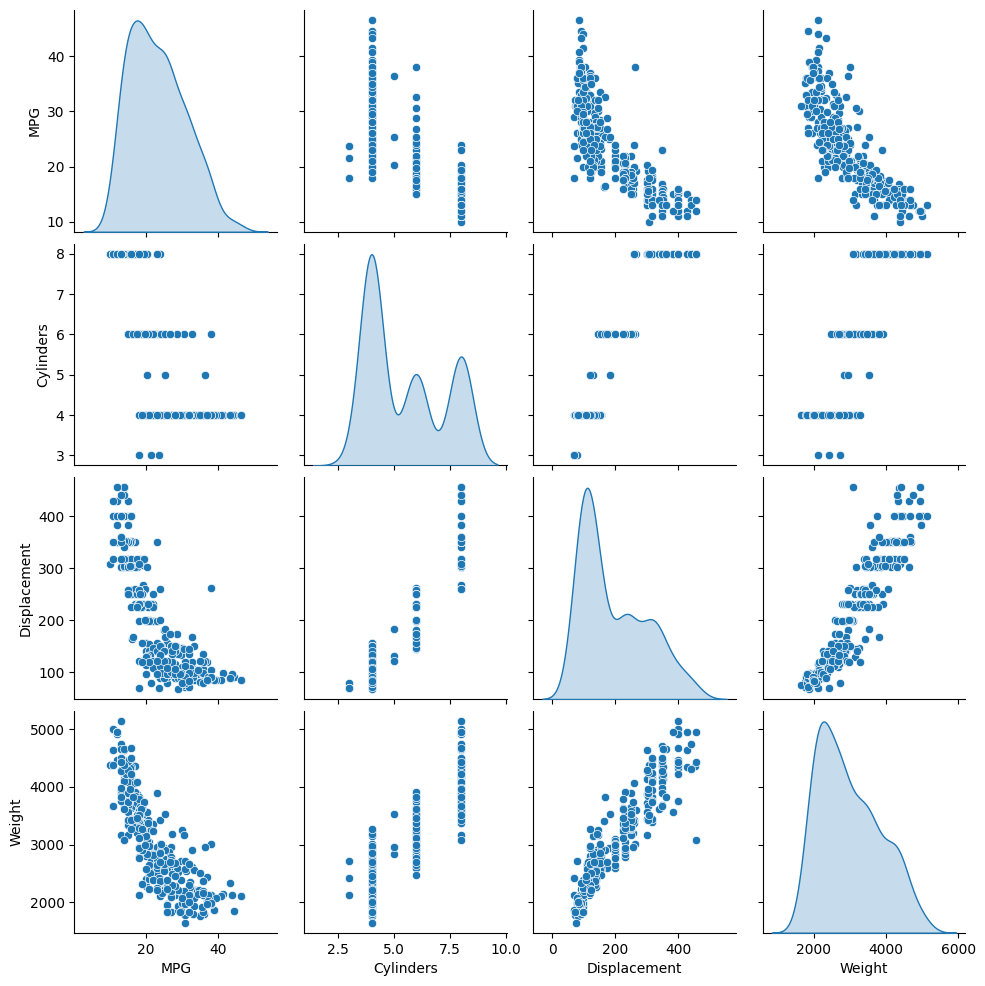

In [87]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [88]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


In [89]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [90]:
# Normalization
train_dataset.describe().transpose()[['mean', 'std']]


,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin,1.573248,0.800988


In [91]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [92]:
train_features


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
146,4,90.0,75.0,2125.0,14.5,74,1
282,4,140.0,88.0,2890.0,17.3,79,1
69,8,350.0,160.0,4456.0,13.5,72,1
378,4,105.0,63.0,2125.0,14.7,82,1
331,4,97.0,67.0,2145.0,18.0,80,3
...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1
229,8,400.0,180.0,4220.0,11.1,77,1
150,4,108.0,93.0,2391.0,15.5,74,3
145,4,83.0,61.0,2003.0,19.0,74,3


In [93]:
normalizer.adapt(np.array(train_features))

In [94]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    1.573]]


In [95]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.72]]


In [96]:
horsepower = np.array(train_features['Horsepower'])
horsepower

array([ 75.,  88., 160.,  63.,  67.,  90.,  60.,  67.,  95.,  88.,  60.,
       180.,  88., 150., 155.,  75., 115., 150.,  90.,  90., 129., 110.,
        90., 110.,  76., 165.,  92.,  88., 100., 150., 122.,  74.,  76.,
        67., 110.,  90.,  65., 150., 150., 220., 165.,  67.,  75., 140.,
        78., 149.,  84., 150., 145., 100.,  75., 170., 200.,  72.,  78.,
        76.,  88., 105.,  53.,  86.,  95.,  75.,  71., 198.,  69., 105.,
       215.,  88.,  87.,  65.,  60.,  68., 129., 145.,  95., 153.,  70.,
       145.,  68.,  70., 100.,  70.,  81.,  95., 225.,  90.,  97., 100.,
        65., 110.,  89., 150., 110.,  95.,  85.,  97.,  60.,  88.,  52.,
        70., 198.,  71.,  90.,  72.,  63., 115.,  90., 135.,  52., 150.,
       170.,  58.,  96., 125.,  92.,  95.,  90.,  95.,  82., 110.,  78.,
        67., 208., 105., 130., 150.,  46.,  90.,  64.,  75.,  85.,  72.,
        95.,  90., 145.,  88., 167., 120., 190.,  78.,  49.,  86., 150.,
        70., 107.,  80., 150., 105., 100., 145.,  8

In [97]:
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)
horsepower_normalizer

In [98]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
146,4,90.0,75.0,2125.0,14.5,74,1
282,4,140.0,88.0,2890.0,17.3,79,1
69,8,350.0,160.0,4456.0,13.5,72,1
378,4,105.0,63.0,2125.0,14.7,82,1
331,4,97.0,67.0,2145.0,18.0,80,3
...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,1
229,8,400.0,180.0,4220.0,11.1,77,1
150,4,108.0,93.0,2391.0,15.5,74,3
145,4,83.0,61.0,2003.0,19.0,74,3


In [99]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer, # layer normalizes the input (mean, std, bias)
    layers.Dense(units=1) # This layer is a fully connected layer with 1 neuron and takes the normalized data as input. (weight, bias)
])
horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [100]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 42ms/step


array([[-0.861],
       [-0.486],
       [ 1.589],
       [-1.207],
       [-1.092],
       [-0.429],
       [-1.294],
       [-1.092],
       [-0.285],
       [-0.486]], dtype=float32)

In [101]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [102]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 719 ms
Wall time: 3.49 s


In [103]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch #  create new column
hist.tail()

,loss,val_loss,epoch
95,3.804963,4.187551,95
96,3.801973,4.193631,96
97,3.801684,4.184423,97
98,3.804200,4.175234,98
99,3.803320,4.188416,99


In [104]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss') # The validation loss
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

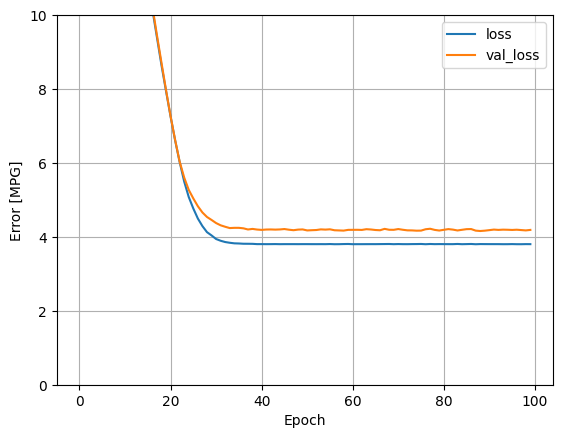

In [105]:
plot_loss(history)

In [106]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [107]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


In [108]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

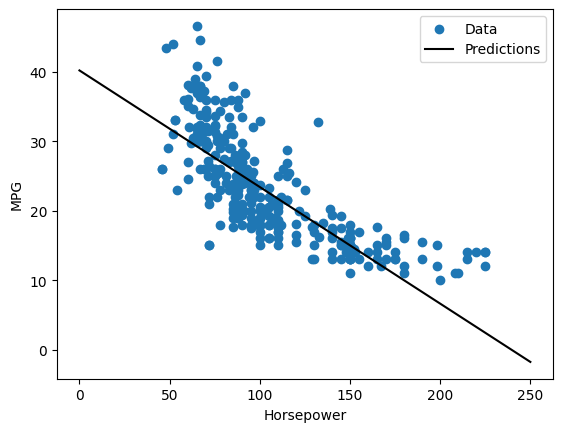

In [109]:
plot_horsepower(x, y)

In [114]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [115]:
linear_model.predict(train_features[:10][:-4])

1/1 [==============================] - 0s 36ms/step


array([[-1.333],
       [-1.251],
       [ 1.571],
       [-2.268],
       [-0.347],
       [-0.518]], dtype=float32)

In [117]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [118]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 734 ms
Wall time: 4.09 s


In [119]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

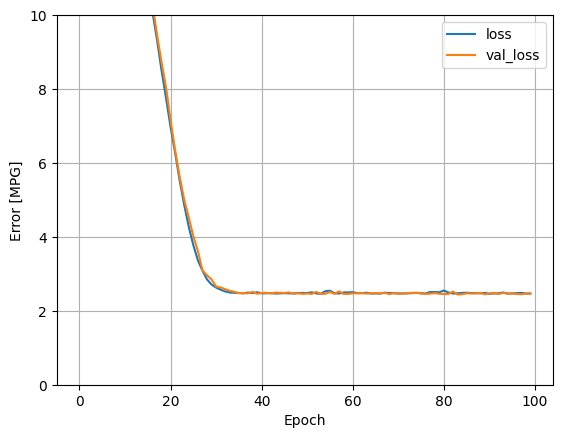

In [121]:
plot_loss(history)

In [120]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [122]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [123]:
dnn_horsepower_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [124]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 703 ms
Wall time: 3.98 s


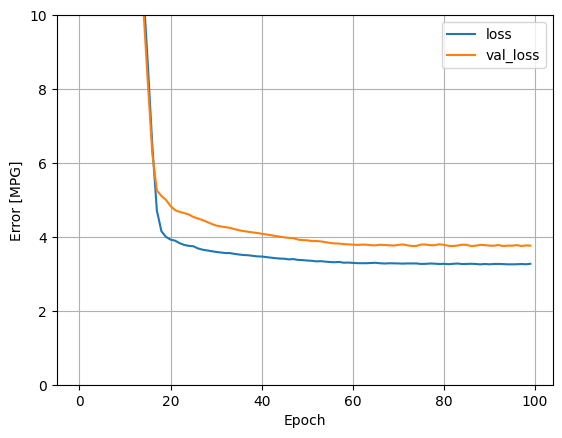

In [125]:
plot_loss(history)

In [126]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


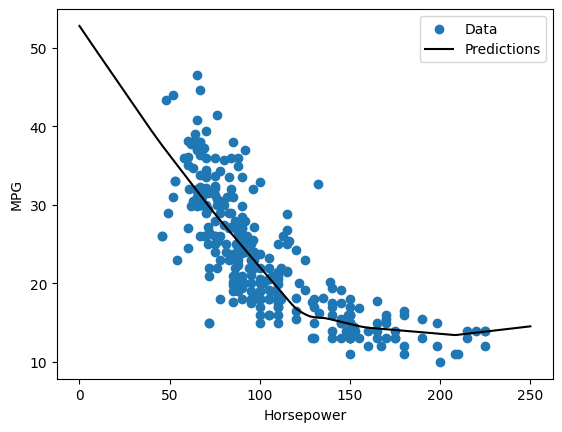

In [127]:
plot_horsepower(x, y)

In [128]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)